<a href="https://colab.research.google.com/github/rlabuonora/CourseraSearch/blob/master/precios_casas_viernes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contenido
1. [Introducción](#introduction)
2. [Análisis Exploratorio](#descriptivo)
    1. [Sub paragraph](#subparagraph1)
3. [Preprocesamiento](#preprocesamiento)
4. [Modelos](#modelos)
5. [Validación](#validacion)
6. [Conclusiones](#conclusiones)



# <a name="introduction">Introducción</a>

Los datos incluyen información sobre 1460 casas en Ames, Iowa que fueron compradas. El objetivo es predecir el valor a la que se vendió cada propiedad.

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import scipy.stats as stats
from scipy.stats import skew, skewtest

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder


from google.colab import drive


In [19]:
# Leer los datos
drive.mount('/content/drive', force_remount = True)
casas = pd.read_csv("/content/drive/My Drive/Tryolabs-ML-Interview/data/train.csv")

# Primeras filas
print(casas.head())



Mounted at /content/drive
   Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]


In [3]:
# Filas y columnas
print(casas.shape)

(1460, 81)


In [4]:
# Tipos de las columnas
print(casas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
# Columnas con datos faltantes
print(casas.isnull().any().sum())

19


In [6]:
# Seleccionar numéricas
numericas = casas.select_dtypes(include = [np.number])

# Columnas numéricas con faltantes
print(casas[numericas.columns[numericas.isnull().any()]].isnull().sum().sort_values(ascending = False))



LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64


In [7]:
# Columnas categóricas
categoricas = casas.select_dtypes(include=[object])

# Columnas categóricas con faltantes
print(casas[categoricas.columns[categoricas.isnull().any()]].isnull().sum().sort_values(ascending = False))



PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrType         8
Electrical         1
dtype: int64


# <a name="descriptivo">Análisis Exploratorio</a>



## Análisis del diccionario

Acá aplicamos un poco de sentido común y vamos columna por columna mejorando la importación. Los pasos que damos acá no entran en el pipeline, por lo que deberíamos estar bastante convencidos de que son las decisiones correctas y seguimos adelante.

Principales decisiones: 

- Drop `MSSubClass` (OK)
- `Condition1` y `Condition2`
- Fechas: 
    - Una dummy para el mes de la venta para captar efectos del mercado
    - Una variable numerica `antiguedad`.
- Consolidar Basement (OK)
- Consolidar Garage
- Uniformizar escalas ordinales



### Variables numéricas

Hay dos tipos de variables: variables que miden metrajes y variables que miden cantidades (cantidad de cuartos, cantidad de baños, etc.). Las que miden cantidades no son normales, por lo que hay que tener en cuenta esto al escalarlas.

#### Continuas

- `LotFrontage` tiene 200 missings.
- `LotArea`: ¿Concentrada en 0?
- ~~`GrLivArea`~~ TODO: analizar en profundidad.
- `MasVnrArea` tiene 8 missings: Imputar con método simple

-  ~~`BsmtFinSF1`~~ 
- ~~`BsmtFinSF2`~~ 
- ~~`BsmtUnfSF`~~  
- ~~`TotalBsmtSF`~~ Es la suma de todas las anteriores. Me quedo solo con esta

- ~~`1stFlrSF`~~
- ~~`2ndFlrSF`~~
- ~~`LowQualFinSF`~~ 

#### Concentradas en 0
No son normales
- ~~`GarageArea`~~
- ~~`WoodDeckSF`~~
- ~~`OpenPorchSF`~~
- ~~`EnclosedPorch`~~
- ~~`3SsnPorch`~~
- ~~`ScreenPorch`~~
- `PoolArea` Si tiene missing deben ser 0s
- `MiscVal`  Tiene Missing

In [0]:
continuas = ["LotArea",      "GrLivArea",   "GarageArea",
             "WoodDeckSF",   "OpenPorchSF", "EnclosedPorch",
             "3SsnPorch",    "ScreenPorch",
             "LowQualFinSF", # No cambia casi nada
             "1stFlrSF",     "2ndFlrSF"]





In [0]:
# TODO: mover esta función a un módulo
def grafico_curtosis(x, x_texto, y_texto):
  eje = sns.distplot(x, kde=False, fit=stats.norm)
  sk = skew(x)
  sk_pval = skewtest(x)[0]
  eje.text(x_texto, y_texto, f'Curtosis:\n{sk:.2f} ({sk_pval:.4f})', fontsize = 14)


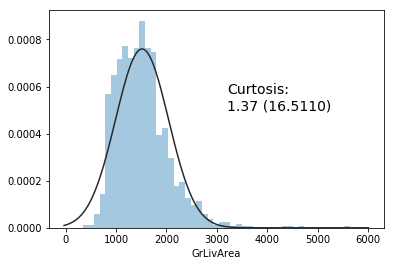

In [10]:
x = casas["GrLivArea"]
grafico_curtosis(x, 3200, 0.0005)


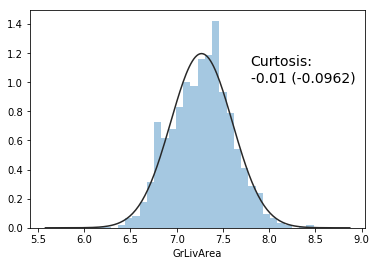

In [11]:
log_x = np.log1p(casas["GrLivArea"])
plt.clf()
grafico_curtosis(log_x, 7.8, 1)



#### Cuentas

- `BsmtFullBath`
- `BsmtHalfBath` Estas dos variables rompen el modelo 
- ~~`FullBath`~~  
- ~~`HalfBath`~~   
- ~~`BedroomAbvGr`~~
- ~~`KitchenAbvGr`~~
- ~~`TotRmsAbvGrd`~~
- ~~`Fireplaces`~~

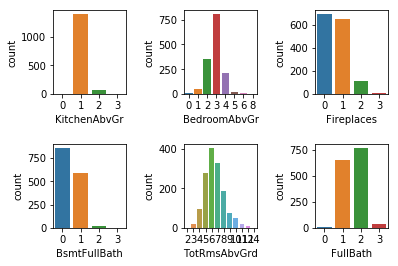

In [21]:
# Cantidad de baños, cantidad de garages
cuentas =   ["KitchenAbvGr", "BedroomAbvGr", "Fireplaces", 
             "BsmtFullBath", 
             #"BsmtFullBath",  
             "TotRmsAbvGrd", "FullBath",     "HalfBath"
             ]   




# Dimensiones del panel
i = 2
j = 3

# Panel de (2, 3)
fig, ax = plt.subplots(2, 3)
fig.subplots_adjust(hspace=0.6, wspace=0.8)

# Ordenar los nombres de las columnas (2, 3) para iterar fácil
cols = np.reshape(np.array(cuentas)[:6], (i, j))

for i in range(2):
    for j in range(3):
        col = cols[i, j]
        sns.countplot(x=col, data=casas, ax = ax[i, j])
        
        







### Variables categóricas

#### No ordinales

- `MSSubClass` - Es el tipo de vivienda combinado con el año de construcción. Eliminarla porque está en otras columnas (`BldgType`, `HouseStyle` y `YearBuilt`).
- ~~`MSZoning`~~
-  ~~`Street`~~
- `Alley` Missing.
- ~~`LotShape`~~
- ~~`LandContour`~~
- ~~`Utilities`~~
- `LotConfig` Empeora el modelo
- `LandSlope` Empeora el modelo
- ~~`Neighborhood`~~
- ~~`BldgType`~~
-  ~~`HouseStyle`~~
- ~~`RoofStyle`~~
- ~~`RoofMatl`~~
- ~`Exterior1st`~
- `Exterior2nd` Empeora el modelo 
- `MasVnrType` - Tiene 8 missings
- ~~`Foundation`~~
- `BsmtFinType1` Missing cuando no hay basement:  Imputar no basement.
- `BsmtFinType2` Missing cuando no hay basemento: Imputar no basement
- ~~`Heating`~~
- ~~`CentralAir`~~
- `Electrical` 1 Missing, imputar la MODA.
- `GarageType` Missing cuando no hay garage.
- ~~`PavedDrive`~~
- `MiscFeature` Missings.
- ~`SaleType`~
- ~`SaleCondition`~







In [0]:
categoricas = ["Street",       "LotShape",     "LandContour",  
               "Neighborhood", "Exterior1st",  "Utilities",
               "BldgType",     "HouseStyle",   "RoofStyle", 
               "RoofMatl",     "PavedDrive",   "SaleCondition",
               "Foundation",   "Heating",      "CentralAir", 
               "LotShape",     "LandContour",  "Utilities", 
               "MSZoning",     "SaleType",    
             # "Exterior2nd",  "LandSlope",    "LotConfig",    Empeoran
             # "Alley",        "Electrical",   "BsmtFinType1", "BsmtFinType2", "GarageType" Tiene Nan
               "outlier"]

#### Ordinales

- `OverallQual`
- `OverallCond`
- `ExterQual`: Ex, Fa, Gd, TA
- `ExterCond`
- `BsmtQual` Missng cuando no tiene Basement: Imputar una cateogria extra
- `BsmtCond` Missing cuando no tiene Basement: Imputar una categoria extra
- `BsmtExposure` Missing cuando no tiene basement: Imputar una categoria extra.
- `HeatingQC`
- `KitchenQual`
- `Functional`
- `FireplaceQu` Missing
- `GarageFinish` Missing.  Dudosa si es ordinal o no ordinal
- `GarageCond` Missing.
- `GarageQual` Missing
- `PoolQC` Missing cuando no tiene pool. Chequear.
- `Fence` Missing cuando no tiene fence. Chequear.


ExterCond: Ex, Fa, Gd, Po, TA



BsmtQual Ex, 
Fa, GdTA     649
NaN     37

In [14]:
ordinales = ["OverallQual",  "OverallCond", "ExterQual",
             "ExterCond",    "BsmtQual",    "BsmtCond",
             "BsmtExposure", "HeatingQC",   "KitchenQual",
             "Functional",   "FireplaceQu", "PoolQC",
             "GarageFinish", "GarageCond",   
             "Fence"] 

# Sacar las cuentas de cada columna
#_ = [print(f'{ordinal}\n{casas[ordinal].value_counts(dropna = False).sort_index()}') for ordinal in ordinales]

# Sacar los valores y verificar el orden
_ = [print(f'{ordinal}\n{casas[ordinal].value_counts(dropna = False).sort_index().index.values}') for ordinal in ordinales]


 

OverallQual
[ 1  2  3  4  5  6  7  8  9 10]
OverallCond
[1 2 3 4 5 6 7 8 9]
ExterQual
['Ex' 'Fa' 'Gd' 'TA']
ExterCond
['Ex' 'Fa' 'Gd' 'Po' 'TA']
BsmtQual
['Ex' 'Fa' 'Gd' 'TA' nan]
BsmtCond
['Fa' 'Gd' 'Po' 'TA' nan]
BsmtExposure
['Av' 'Gd' 'Mn' 'No' nan]
HeatingQC
['Ex' 'Fa' 'Gd' 'Po' 'TA']
KitchenQual
['Ex' 'Fa' 'Gd' 'TA']
Functional
['Maj1' 'Maj2' 'Min1' 'Min2' 'Mod' 'Sev' 'Typ']
FireplaceQu
['Ex' 'Fa' 'Gd' 'Po' 'TA' nan]
PoolQC
['Ex' 'Fa' 'Gd' nan]
GarageFinish
['Fin' 'RFn' 'Unf' nan]
GarageCond
['Ex' 'Fa' 'Gd' 'Po' 'TA' nan]
Fence
['GdPrv' 'GdWo' 'MnPrv' 'MnWw' nan]


In [15]:
{
  "ExterQual"    : ['Ex' 'Fa' 'Gd' 'TA'],
  "ExterCond"    : ['Ex' 'Fa' 'Gd' 'Po' 'TA'],
  "BsmtQual"     : ['Ex' 'Fa' 'Gd' 'TA' nan],
  "BsmtCond"     : ['Fa' 'Gd' 'Po' 'TA' nan],
  "BsmtExposure" : ['Av' 'Gd' 'Mn' 'No' nan],
  "HeatingQC"    : ['Ex' 'Fa' 'Gd' 'Po' 'TA'],
  "KitchenQual"  : ['Ex' 'Fa' 'Gd' 'TA'],
  "Functional"   : ['Maj1' 'Maj2' 'Min1' 'Min2' 'Mod' 'Sev' 'Typ'],
  "FireplaceQu"  : ['Ex' 'Fa' 'Gd' 'Po' 'TA' nan],
  "PoolQC"       : ['Ex' 'Fa' 'Gd' nan],
  "GarageFinish" : ['Fin' 'RFn' 'Unf' nan],
  "GarageCond"   : ['Ex' 'Fa' 'Gd' 'Po' 'TA' nan],
  "Fence"        : ['GdPrv' 'GdWo' 'MnPrv' 'MnWw' nan]
}

SyntaxError: ignored

In [0]:
ordinales = ["OverallQual",  "OverallCond", "ExterQual",                  
             #"BsmtQual",    "BsmtCond", "BsmtExposure", 
             #"GarageFinish", "GarageCond",  "PoolQC",
             #"FireplaceQu", "Fence", "ExterCond"
            "HeatingQC",   "KitchenQual", "Functional"] 

#### Fechas
- `YearBuilt`
- `YearRemodAdd`
- `GarageYrBlt`
- `MoSold`
- `YrSold`

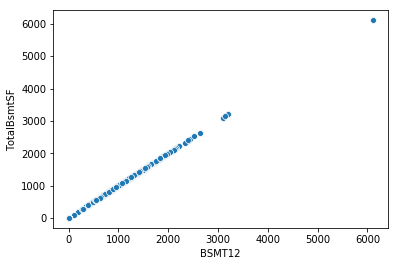

In [24]:

basement = casas[["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]].copy()
basement["BSMT12"] = basement["BsmtFinSF1"] + basement["BsmtFinSF2"] + basement["BsmtUnfSF"]
sns.scatterplot(x="BSMT12", y="TotalBsmtSF", data=basement) # TODO: agregar caption con la conclusion

## Variable Objetivo

La variable objetivo `SalesPrice` tiene una distribución asimétrica, con la cola larga a la derecha. La casa más barata salió \$ 34.900 y la más cara \$755.000

### Estadísticos Descriptivos

In [0]:
casas[["SalePrice"]].describe()

###  Normalidad



### Correlación con columnas de X

La correlación de las columnas nos da una pista de por donde vale la pena empezar a trabajar. La variable más importante parece ser OverallQual.

In [0]:
# Correlaciones con SalePrice
corr_sales_price = casas.corr()["SalePrice"]

# Solo las mayores que 0.63 ordenadas descendiendo
corrs_altas = corr_sales_price[corr_sales_price > 0.3].sort_values(ascending = False)
print(corrs_altas)


### Outliers

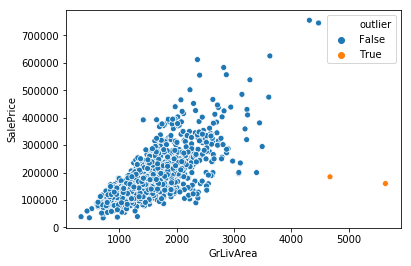

In [25]:

# sns.pairplot(casas[["OverallQual", "OverallCond", "SalePrice", "GrLivArea"]])
# De este gráfico se ven dos outliers en la relación SalePrice vs GrLivArea

casas["outlier"] = np.logical_and(casas["GrLivArea"] > 4000, 
                                  casas["SalePrice"] < 300000)

sns.scatterplot(x="GrLivArea", y="SalePrice", hue="outlier", data=casas)



- `OverallCond` tiene correlación negativa (-0.077856) con `SalePrice` 
- 2 outliers entre `GrLivingArea` y `SalePrice`
- La relación entre `GrLivingArea` y `SalePrice` tiene forma de cono
- Varias de la features continuas tienen skew.

## Otras columnas de X

TODO: ¿cuáles son?


In [0]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
# https://stackoverflow.com/questions/39409866/correlation-heatmap
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

## Conclusiones

- Normalizar `SalesPrice`
- Marcar Outliers
- Principales variables a tener en cuenta para el modelo
  - Visualización y descriptivos (¿Ceros?) POR LO MENOS PARA LAS IMPORTANTES
- Codificar las binarias y las categóricas
- Escalar las continuas

# <a name="preprocesamiento">Preprocesamiento</a>

En esta sección implementamos los cambios sugeridos en la sección anterior para dejar los datos listos para los modelos. Usamos una custom `Pipeline` para cada paso en el preprocesamiento. 



### Imputar datos faltantes

### Codificar variables Categóricas




### Limpiar las fechas

### Normalizar y/o Escalar variables numéricas

TODO

## Agregar Variables al cuadrado

# <a name="modelos">Modelos</a>

Split para validar

In [0]:





transform_categoricas = Pipeline(steps=[
    # Imputar faltantes
    ('onehot', OneHotEncoder(handle_unknown="ignore"))  # TODO investigar handle_unknown y drop='first'
                                                        # ignore le pone todo 0 a las que tienen missing
])

transform_continuas = Pipeline(steps = [
    # Imputar faltantes continuas con la MODA/0
    # Normalizar
    ('scale', StandardScaler())
])

transform_ordinales = Pipeline(steps = [
   ('ord', OrdinalEncoder())
])


# TODO: Linkear ejemplo en docs

# ColumnTransformer aplica las pipelines en paralelo y concatena las columnas resultantes
preprocesador = ColumnTransformer(
  transformers=[
      ('cat', transform_categoricas, categoricas),
      ('num', transform_continuas, continuas),
      ('ord', transform_ordinales, ordinales),
      ('cnts', 'passthrough', cuentas )
  ]
)

# Transform Target
# https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py


# Preprocesar + modelo
clf = Pipeline(steps = [
    # Remove outliers
    ('preprocess', preprocesador),
    # Polynomial Features
    ('modelo', LinearRegression())
])




In [27]:
# Extraer X e y como arrays
X = casas[categoricas + continuas  + ordinales + cuentas]
y = casas["SalePrice"]

# Splitearlos
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Fit pipeline
clf.fit(X_train, y_train)

# Score
clf.score(X_test, y_test)

0.8815467223036825

### Modelo Línea de Base



In [0]:
# Elegimos un modelo lineal sin regularización
lin_reg = LinearRegression()

# Lo entrenamos con los datos de train
lin_reg.fit(X_train, y_train)

# Predecimos con datos limpios
y_pred = lin_reg.predict(X_test)

# Evaluamos la métrica
print(f'MSE: {mean_squared_error(y_true = y_test, y_pred = y_pred):.4f}') # Formatear numero con 4 dígitos dps de la ,
print(f'R2: {r2_score(y_true = y_test, y_pred = y_pred):.4f}') # Formatear numero con 4 dígitos dps de la ,

# Probar:
# Sacar outliers
# Polynomial Features




## LASSO

## Ridge

## Elastic Net

# <a name="validacion">Validación</a>



## Cross Validation

## Feature Selection

## Error Analysis

Normalidad de los errores.

# <a name="conclusiones">Conclusiones</a>

Lasso funciona bien porque hay muchas columnas correlacionadas.